# Portfolio Methodolgy

1. DGI/Growth Names - Rebalance every 6 months picking around 2 - 3 names from CA and US universe
    - Sell Covered Calls on names and re-enter if called away.
    - **GTC Stop Limit of 5% on each name**
2. VAA/PAA - Rebalance every month on trading day 1
3. LEAPS - Rebalance every 3 months picking around 3 - 8 names from US universe (high growth potential names)
    - Current Holdings: LOPE STOR PNW SBUX
    - LOPE Earnings: Nov 8
    - PNW Earnings: Nov 8
    - SBUX Earnings: Jan 23
        - **Exit Criteria: When the call option drops below 60 delta**
4. Short Vol - Short SPX Spreads at the beginning of the month and hold until second or last week to maturity
    - Potentially long UVXY/VXX puts at beginning of the month with bracket orders
    - **Short ATM SPX Put spreads around 25 points wide**
        - **Long bi-weekly unit puts, around -7% or so of SPX spot (or something with a cost of 15% of the credit)**
        - **The SPX put spread will have a capped max loss of 2,500 per contract, while in low volatility, the bi-weekly units are severely underpriced and will explode 10X to 20X in value if the long strike in the spread gets tested. Vega and Gamma play a huge factor in the repricing of these units.**
        - Initiate the units every 2 weeks letting them run to expiry
    - ***When in lower vol environment or when skew is less pronounced in high vol environments, it is possible to select spreads and units with the same expiry and still receive a deccent net credit. Otherwise, when IV is very high, check if same expiries are possible, otherwise choose units that expire in half the time.***
5. Barbell Hedging
    - Long SPX puts or VIX calls during high crisis potential moments
        - Initiate bracket orders with SPX Puts: +/- 30% of Cost Basis
    - Check VIX Futures volume trends and see impact of Feb 5, 2018
    - Only trade 4 naked SPX puts in Reg accounts
        - Sell half into profits/losses 
    - Only trade 6 3:1 Put back ratios in Reg Account: Leg into these positions because of how illiquid the market is
    - Take losses immediately (10% - 30% of Cost Basis)
    - NEVER EVER try to put on a position of the market is illiquid: YOU WILL get filled at horrible prices
    - **Put on 1-5 Delta strangles on the open of the day and close position at the end of the day around 2 pm to 3 pm**
6. Treasuries - Re-establish monthly bills beginning of month or at maturity
7. Earnings
    - Filter stocks with market cap > 500M and with post-earnings returns greater than 2% in magnitude for at least 3 quarters
    - Then filter stocks whose options have bid-ask spreads less than 1 dollar ATM
    - Aggregate all insider share buys and sells and calculate the ratio Buy/Sells
        - Candidates for Puts have Buy/Sell < 0.5
        - Candidates for Calls have Buy/Sell > 2

##### Strategy Weights
|Strategy|Weight|Last Rebal|Next Check|Next Full Rebal|
|-|-|-|-|-|
|VAA/PAA|25%|11/01/2018|12/01/2018|12/01/2018|
|LEAPs|5%|11/01/2018|12/01/2018|01/01/2019|
|Short Vol|2%|NA|NA|NA|
|Barbell Hedging|1.5%|11/06/2018|11/09/2018|11/19/2018|
|Treasuries|60%|11/01/2018|11/29/2018|12/01/2018|

## Key Modules to Run

- fundamental_data_collect.py to run monthly to collected latest financial statements and key stats from yahoo
- finstatement_cleaning.py to run right after fundamental_data_collect.py to create cleaned data for earnings plays



In [1]:
# Importing necessary models
import warnings
warnings.filterwarnings('ignore')

import smtplib
import pandas as pd
import numpy as np
import datetime as dt
import pandas.stats.moments as st
import time
%matplotlib inline
from bs4 import BeautifulSoup as bs
import requests
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sqlalchemy import *
from sqlalchemy import create_engine
import calendar
import sqlite3 as sql
pd.options.display.float_format = '{:,.4f}'.format

init_notebook_mode(connected=True)

import os
main_dir = os.getcwd()

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\DataCollection')

from alphavantage import *
from yahoo_query import *
from option_slam_earnings import *
from reuters_query import reuters_query, reuters_insiders
from alphaquery import alphaquery

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Options')
from optionsFunctions import *

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Earnings')
from yahoo_earnings import *
from lookup_earnings import lookup_earnings

os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Trading\\Modules\\Processing')
from hv_calc import *

os.chdir(main_dir)

dbs_dir = 'C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\DBs'

os.chdir(dbs_dir)

earn_engine = create_engine('sqlite:///earningsHistory.db', echo=False)
yahoo_engine = create_engine('sqlite:///yahoo.db', echo = False)
reuters_engine = create_engine('sqlite:///reuters.db', echo=False)

# Allocate Smartly Checking

In [2]:
# Short Call Assignment Price - 287.5

portfolio_value =  200000

as_lst = ['DBC',
        'HYG',
        'IEF',
        'IWM',
        'LQD',
        'QQQ',
        'SPY',
        'VNQ']
as_wgt = [0.0,
        0.0,
        1.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0]

as_df = pd.DataFrame({'Allocation': as_wgt}, index = as_lst)
curr_spot = curr_batch_quotes(as_lst)
as_df = pd.concat([as_df,curr_spot[['price']]], axis = 1)

as_df['Market Value'] = portfolio_value*as_df.Allocation
as_df['Holdings'] = np.round(as_df['Market Value']/as_df.price,0)

as_df

,Allocation,price,Market Value,Holdings
symbol,,,,
DBC,0.0000,15.4850,0.0000,0.0000
HYG,0.0000,83.3100,0.0000,0.0000
IEF,1.0000,102.3400,"200,000.0000","1,954.0000"
IWM,0.0000,144.7200,0.0000,0.0000
LQD,0.0000,112.5250,0.0000,0.0000
QQQ,0.0000,165.0300,0.0000,0.0000
SPY,0.0000,265.6200,0.0000,0.0000
VNQ,0.0000,80.3000,0.0000,0.0000


## Checking market correlations - https://fang-trading-dashboard.herokuapp.com

In [3]:
# rolling_window = 60
# plot_window = 10000

# corr_df, sector_df = check_mkt_corr(rolling_window, plot_window)
# print(corr_df.tail())

In [4]:
# ((sector_df.dropna() + 1).cumprod()-1).tail()

In [5]:
# corr_df.iloc[:,:-2].plot(figsize = (20,10))

## Earnings

In [3]:
# Fin Statement 

def balancesheet_sum(balance_sheet, period):
    balance_sheet = balance_sheet.fillna(np.nan)
    
    bs_summary = balance_sheet[[period, 'cash', 'totalCurrentAssets', 'totalAssets', 'totalLiab','totalStockholderEquity']]

    bs_ratios = balance_sheet[[period]]

    bs_ratios['current_ratio'] = pd.to_numeric(balance_sheet['totalCurrentAssets'])/pd.to_numeric(balance_sheet['totalCurrentLiabilities'])
    bs_ratios['total_debt_equity_ratio'] = pd.to_numeric(balance_sheet['totalCurrentLiabilities'])/pd.to_numeric(balance_sheet['totalStockholderEquity'])

    bs_summary[bs_summary.columns.tolist()[1:]] = bs_summary[bs_summary.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    bs_ratios[['current_ratio_changes','total_debt_equity_changes']] = bs_ratios[['current_ratio','total_debt_equity_ratio']].pct_change()
    bs_summary = bs_summary.merge(bs_ratios, on = period)
    bs_summary['Underlying'] = ticker
    bs_summary = bs_summary.set_index('Underlying')
    return bs_summary

def cashflows_sum(cashflows, period):
    cashflows['fcf'] = pd.to_numeric(cashflows['totalCashFromOperatingActivities']) - pd.to_numeric(cashflows['totalCashflowsFromInvestingActivities'])
    cashflow_sum = cashflows[[period, 'fcf', 'capitalExpenditures', 'dividendsPaid', 'investments']].fillna(0)
    cashflow_sum[cashflow_sum.columns.tolist()[1:]] = cashflow_sum[cashflow_sum.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    cashflow_sum['changeToOperatingActivities'] = pd.to_numeric(cashflows['changeToOperatingActivities'])/pd.to_numeric(cashflows['totalCashFromOperatingActivities'])
    cashflow_sum['Underlying'] = ticker
    cashflow_sum = cashflow_sum.set_index('Underlying')
    
    return cashflow_sum


def income_summary(incomestatement, period):

    income_sum = incomestatement[[period, 'grossProfit','operatingIncome', 'netIncome', 'totalRevenue', 'totalOperatingExpenses', 'researchDevelopment']]
    income_sum = income_sum.fillna(np.nan)
    income_ratios = income_sum[[period]]
    income_ratios['gross_margin'] = pd.to_numeric(income_sum['grossProfit'])/pd.to_numeric(income_sum['totalRevenue'])
    income_ratios['operating_margin'] = pd.to_numeric(income_sum['operatingIncome'])/pd.to_numeric(income_sum['totalRevenue'])
    income_ratios['net_profit_margin'] = pd.to_numeric(income_sum['netIncome'])/pd.to_numeric(income_sum['totalRevenue'])
    income_sum[[x + '_changes' for x in income_ratios.columns.tolist()[1:]]] = income_ratios[income_ratios.columns.tolist()[1:]]
    income_sum[income_sum.columns.tolist()[1:]] = income_sum[income_sum.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
    income_sum = income_sum.merge(income_ratios, on = period)
    income_sum['Underlying'] = ticker
    income_sum = income_sum.set_index('Underlying')
    
    return income_sum

def score_statement(statement):

    short_score = 0
    long_score = 0

    require_positives = ['cash', 'current_ratio_changes', 'fcf', 'capitalExpenditures', 'investments',
                         'grossProfit', 'operatingIncome', 'netIncome', 'totalRevenue' ,'researchDevelopment',
                         'gross_margin_changes','net_profit_margin_changes','operating_margin_changes',
                         'gross_margin','operating_margin','net_profit_margin','earnings','revenue']
    require_negatives = ['totalLiab','total_debt_equity_ratio','total_debt_equity_changes','totalOperatingExpenses']

    for idx, row in statement.T.iterrows():
        num_of_periods = len(statement)
        if idx == 'year' or idx == 'quarter':
            continue
        curr_line_check = sum(row.values > 0)

        if idx in require_positives and curr_line_check == num_of_periods:
            long_score += 1

        if idx in require_positives and curr_line_check == 0:
            short_score += 1

        if idx in require_negatives and curr_line_check == 0:
            long_score += 1

        if idx in require_negatives and curr_line_check == num_of_periods:
            short_score += 1
            
    return [long_score, short_score]

def yahoo_assess(yahoo_info, ticker):
    annual_statements = []
    quarterly_statements = []

    for k, v in yahoo_info.items():
        current_table = v[v.index == ticker].drop_duplicates().replace('na',np.nan)
        if len(current_table) > 0:
            if 'BalanceSheet' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                balancesheet = balancesheet_sum(current_table, period)
                if period == 'year':
                    annual_statements.append(balancesheet)
                else:
                    quarterly_statements.append(balancesheet)
                #yahoo_info[k] = balancesheet
            elif 'CashFlow' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                cashflows = cashflows_sum(current_table, period)
                if period == 'year':
                    annual_statements.append(cashflows)
                else:
                    quarterly_statements.append(cashflows)
                #yahoo_info[k] = cashflows
            elif 'annualEarnings' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                earnings = current_table
                earnings[earnings.columns.tolist()[1:]] = earnings[earnings.columns.tolist()[1:]].apply(lambda x: pd.to_numeric(x)).pct_change()
                #yahoo_info[k] = earnings
            elif 'IncomeStatement' in k:
                period = list(filter(lambda x: x in ['year','quarter'], current_table.columns.tolist()))[0]
                incomestatement = income_summary(current_table, period)
                if period == 'year':
                    annual_statements.append(incomestatement)
                else:
                    quarterly_statements.append(incomestatement)
                #yahoo_info[k] = incomestatement
            elif k == 'finData':
                finData = current_table[['earningsGrowth','revenueGrowth','freeCashflow','totalCash']].drop_duplicates()
            else:
                profile = current_table[['industry','sector']].drop_duplicates()

    annual_statements = pd.concat(annual_statements, axis = 1)
    annual_statements = annual_statements.T[~annual_statements.T.index.duplicated(keep='first')].T
    annual_statements['year'] = pd.to_datetime(annual_statements['year'])
    #annual_statements[['earnings','revenue']] = earnings[['earnings','revenue']]
    annual_statements['earnings'] = earnings['earnings'].values
    annual_statements['revenue'] = earnings['revenue'].values
    annual_statements = annual_statements.tail(len(annual_statements) - 1)

    quarterly_statements = pd.concat(quarterly_statements, axis = 1)
    quarterly_statements = quarterly_statements.T[~quarterly_statements.T.index.duplicated(keep='first')].T
    quarterly_statements['quarter'] = pd.to_datetime(quarterly_statements['quarter'])
    quarterly_statements = quarterly_statements.tail(len(quarterly_statements) - 1)

    ticker_profile = profile.join(finData)

    annual_scores = score_statement(annual_statements)
    quarterly_scores = score_statement(quarterly_statements)

    ticker_profile.loc[ticker, 'annualLongScore'] = annual_scores[0]
    ticker_profile.loc[ticker, 'annualShortScore'] = annual_scores[1]
    ticker_profile.loc[ticker, 'quarterlyLongScore'] = quarterly_scores[0]
    ticker_profile.loc[ticker, 'quarterlyshortScore'] = quarterly_scores[1]

    return ticker_profile, annual_statements, quarterly_statements

def convertReportDate(reportdate):
    curr_date = dt.datetime.strptime(reportdate.split(' ')[-1], '%b-%y')
    date_range = calendar.monthrange(curr_date.year,curr_date.month)
    date = dt.datetime(curr_date.year,curr_date.month,date_range[1])
    return date

In [4]:
def reuters_assess(ticker, reuters_info):
    reuters_fundamentals = []

    reuters_long_score = 0
    reuters_short_score = 0

    for k, v in reuters_info.items():
        if k in ['earningsAnalysis','efficiency','performanceSummary','salesAnalysis']:
            continue
        current_table = v[v.index == ticker].drop_duplicates()
        if len(current_table) > 0:
            if 'PullDate' in current_table.columns:
                current_table = current_table.sort_values('PullDate', ascending = False)
                current_table = current_table[current_table['PullDate'] == current_table.PullDate.values[0]]
                del current_table['PullDate']

            if k == 'overviews':
                reuter_overview = current_table[['LastPrice', 'High52Week','Low52Week']]
            if k in ['dividends', 'financialStrength','growthRates','managementAbilities','profitability']:
                reuters_fundamentals.append(current_table)
                fund_table = current_table.set_index('Field')
                for field in fund_table.index:
                    if field not in ['LT Debt to Equity (MRQ)','Total Debt to Equity (MRQ)','Effective Tax Rate (TTM)','Effective Tax Rate - 5 Yr. Avg.']:
                        if fund_table.loc[field,'Company'] > fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] > fund_table.loc[field,'sector']:
                            reuters_long_score += 1
                        if fund_table.loc[field,'Company'] < fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] < fund_table.loc[field,'sector']:
                            reuters_short_score += 1
                    elif field in ['LT Debt to Equity (MRQ)','Total Debt to Equity (MRQ)']:
                        if fund_table.loc[field,'Company'] > fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] > fund_table.loc[field,'sector']:
                            reuters_short_score += 1
                        if fund_table.loc[field,'Company'] < fund_table.loc[field,'industry'] and fund_table.loc[field,'Company'] < fund_table.loc[field,'sector']:
                            reuters_long_score += 1

                if k == 'dividends':
                    try:
                        if fund_table.loc['Dividend Yield', 'Company'] > fund_table.loc['Dividend Yield - 5 Year Avg', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Dividend Yield', 'Company'] < fund_table.loc['Dividend Yield - 5 Year Avg', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'growthRates':
                    try:
                        if fund_table.loc['Sales (TTM) vs TTM 1 Yr. Ago', 'Company'] > fund_table.loc['Sales - 5 Yr. Growth Rate', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Sales (TTM) vs TTM 1 Yr. Ago', 'Company'] < fund_table.loc['Sales - 5 Yr. Growth Rate', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    try:
                        if fund_table.loc['EPS (TTM) vs TTM 1 Yr. Ago', 'Company'] > fund_table.loc['EPS - 5 Yr. Growth Rate', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['EPS (TTM) vs TTM 1 Yr. Ago', 'Company'] < fund_table.loc['EPS - 5 Yr. Growth Rate', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'managementAbilities':
                    try:
                        if fund_table.loc['Return on Assets (TTM)', 'Company'] > fund_table.loc['Return on Assets - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Assets (TTM)', 'Company'] < fund_table.loc['Return on Assets - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Return on Investment (TTM)', 'Company'] > fund_table.loc['Return on Investment - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Investment (TTM)', 'Company'] < fund_table.loc['Return on Investment - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    
                    try:
                        if fund_table.loc['Return on Equity (TTM)','Company'] > fund_table.loc['Return on Equity - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Return on Equity (TTM)','Company'] < fund_table.loc['Return on Equity - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

                if k == 'profitability':
                    try:
                        if fund_table.loc['Gross Margin (TTM)', 'Company'] > fund_table.loc['Gross Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Gross Margin (TTM)', 'Company'] < fund_table.loc['Gross Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['EBITD Margin (TTM)', 'Company'] > fund_table.loc['EBITD - 5 Yr. Avg', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['EBITD Margin (TTM)', 'Company'] < fund_table.loc['EBITD - 5 Yr. Avg', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Operating Margin (TTM)','Company'] > fund_table.loc['Operating Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Operating Margin (TTM)','Company'] < fund_table.loc['Operating Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                        
                    try:
                        if fund_table.loc['Pre-Tax Margin (TTM)','Company'] > fund_table.loc['Pre-Tax Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Pre-Tax Margin (TTM)','Company'] < fund_table.loc['Pre-Tax Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None
                    
                    try:
                        if fund_table.loc['Net Profit Margin (TTM)','Company'] > fund_table.loc['Net Profit Margin - 5 Yr. Avg.', 'Company']:
                            reuters_long_score += 1
                        if fund_table.loc['Net Profit Margin (TTM)','Company'] < fund_table.loc['Net Profit Margin - 5 Yr. Avg.', 'Company']:
                            reuters_short_score += 1
                    except:
                        None

    reuters_fundamentals = pd.concat(reuters_fundamentals, axis = 0)
    reuter_overview.loc[ticker, 'longScore'] = reuters_long_score
    reuter_overview.loc[ticker, 'shortScore'] = reuters_short_score
    return reuter_overview, reuters_fundamentals

def aggregate_txns_date(trade_date):
    
    trade_month = trade_date.month
    trade_year = trade_date.year
    if trade_month <= 3:
        return dt.datetime(trade_year,3,31).date()
    elif trade_month <= 6:
        return dt.datetime(trade_year,6,30).date()
    elif trade_month <= 9:
        return dt.datetime(trade_year,9,30).date()
    else:
        return dt.datetime(trade_year,12,31).date()

In [7]:
month = 12
year = 2018
check_options = True
days_list = list(range(17, 21))

start_time = time.time()

week_earnings = []

for i in days_list:
    date_lookup = '{0}-{1}-{2}'.format(year,month, (str(i)))
    curr_earnings = date_earnings(date_lookup)
    curr_earnings = curr_earnings[curr_earnings['Call Time'].isin(['After Market Close', 'Before Market Open'])]
    curr_earnings['EarningsDate'] = date_lookup
    week_earnings.append(curr_earnings)
    
curr_earnings = pd.concat(week_earnings,axis = 0)

focus_names = []
max_spread = 1

for ticker in curr_earnings.index:
    try:
        curr_options = all_options(ticker, 100, 1)
    except:
        curr_options = []
    
    if len(curr_options) == 0:
        continue
    elif (curr_options['Ask'] - curr_options['Bid']).mean() <= max_spread:
        focus_names.append(ticker)
    else:
        continue
        
curr_earnings = curr_earnings[curr_earnings.index.isin(focus_names)]
acs = curr_earnings[curr_earnings['Call Time'] == 'After Market Close']
bcs = curr_earnings[curr_earnings['Call Time'] == 'Before Market Open']

## Filtering Market Cap
curr_table = pd.read_sql_query('SELECT * FROM overviews WHERE Underlying IN ' + str(tuple(curr_earnings.index)),
                               con = reuters_engine, index_col = 'Underlying').drop_duplicates()
curr_table = curr_table[curr_table['Market Cap(Mil.)'] > 500]
curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
curr_table = curr_table.sort_values('PullDate', ascending = False)[~curr_table.index.duplicated(keep='first')]

selected_names = curr_table.index.tolist()

### Filtering Option Spread

if check_options:
    options_dict = {}

    for name in selected_names:

        try:
            curr_options = all_options(name,100,1,moneyness=0.1)
            if len(curr_options) > 0 and (curr_options['Ask'] - curr_options['Bid']).mean() < 1:
                options_dict[name] = curr_options
        except:
            None

    selected_names = list(options_dict.keys())

### Filtering IV vs HV
vols_list = []

for selected_name in selected_names:
    curr_vol = historical_data(selected_name, dt.datetime(2018,1,1))[['daily_ann','intra_ann','ovrnt_ann']].tail(1)
    curr_vol.index = [selected_name]
    
    aq = alphaquery(selected_name)
    
    curr_iv = aq.vol_df.loc[['Implied Volatility (Calls)', 'Implied Volatility (Puts)', 
                             'Put-Call Implied Volatility Ratio',
                             'Implied Volatility Skew'],['20-Day']].T
    curr_iv.index = [selected_name]
    vols_list.append(curr_vol.join(curr_iv))
    
hv_df = pd.concat(vols_list,axis = 0)

further_reduce = hv_df[(hv_df['intra_ann'] > hv_df['Implied Volatility (Calls)']) &
                       (hv_df['intra_ann'] > hv_df['Implied Volatility (Puts)'])].dropna().sort_values('intra_ann')
selected_names = further_reduce.index.tolist()

## Getting Insider Trading Data
insiderstxns_dict = {}

for ticker in selected_names:
    insider_trades = reuters_insiders(ticker)
    try:
        insider_trades['Trading Date'] = pd.to_datetime(insider_trades['Trading Date'])
        insider_trades['Trading Date'] = insider_trades['Trading Date'].apply(aggregate_txns_date)
        insiderstxns_dict[ticker] = insider_trades
    except:
        insiderstxns_dict[ticker] = []

insider_agg_lst = []

txns_time = dt.date(2018,1,1)

for ticker,txns in insiderstxns_dict.items():
    try:
        curr_insider_agg = txns[txns['Trading Date'] >= txns_time]
        curr_insider_agg = curr_insider_agg.groupby(['Type']).agg({'Shares Traded': 'sum'}).T
        curr_insider_agg.index = [ticker]
    except:
        continue
    
    insider_agg_lst.append(curr_insider_agg)
    
insider_agg = pd.concat(insider_agg_lst,axis = 0)
insider_agg['BuyToSell'] = insider_agg['Buy']/insider_agg['Sell']

further_reduce = further_reduce.join(insider_agg).join(curr_earnings[['Call Time',
                                                                      'EarningsDate']], how = 'left').sort_values(['EarningsDate',
                                                                                                                   'Call Time'],ascending = True)
print("--- %s seconds ---" % (time.time() - start_time))
further_reduce

--- 156.0804443359375 seconds ---


,daily_ann,intra_ann,ovrnt_ann,Implied Volatility (Calls),Implied Volatility (Puts),Put-Call Implied Volatility Ratio,Implied Volatility Skew,Buy,Gift,Sell,BuyToSell,Call Time,EarningsDate
ORCL,0.3224,0.4375,0.2039,0.3715,0.3717,1.0005,0.1002,"11,686,641.0000",nan,"11,272,610.0000",1.0367,After Market Close,2018-12-17
JBL,0.3179,0.5921,0.2120,0.4694,0.4823,1.0275,0.0532,"1,171,710.0000",nan,"1,100,711.0000",1.0645,After Market Close,2018-12-18
FDX,0.3972,0.6931,0.1882,0.3901,0.3840,0.9844,0.0884,"302,429.0000","151,385.0000","174,731.0000",1.7308,After Market Close,2018-12-18
MU,0.5667,1.1448,0.5091,0.6218,0.6175,0.9931,0.0790,"623,007.0000",nan,"520,819.0000",1.1962,After Market Close,2018-12-18
CTAS,0.3098,0.5911,0.1485,0.3675,0.3614,0.9834,0.0754,"381,260.0000",314.0000,"150,095.0000",2.5401,After Market Close,2018-12-19
PAYX,0.2152,0.4634,0.1769,0.3051,0.3039,0.9961,0.1462,"559,567.0000","1,978.0000","494,042.0000",1.1326,Before Market Open,2018-12-19
ACN,0.2275,0.3675,0.1696,0.2900,0.2888,0.9959,0.1146,"576,849.0000","5,906.0000","417,913.0000",1.3803,Before Market Open,2018-12-20
SAFM,0.3767,0.7265,0.0903,0.4795,0.4606,0.9606,0.1010,"130,974.0000",235.0000,"61,598.0000",2.1263,Before Market Open,2018-12-20


In [8]:
# Querying Info from DBs
os.chdir(dbs_dir)
namesToExclude = []

selected_names = further_reduce.index.tolist()

selected_names = list(filter(lambda x: x not in namesToExclude, selected_names))

earnings_query = 'SELECT * FROM postEarningsReturns WHERE Underlying IN ' + str(tuple(selected_names))

earnings_info = pd.read_sql_query(earnings_query, con = earn_engine, index_col = 'Underlying')
earnings_info['earningsDate'] = pd.to_datetime(earnings_info['earningsDate'])

inspector = inspect(yahoo_engine)

irrelevant_yahoo = ['insiderHolders', 'insiderTxns', 'institutionOwners','quarterlyEarnings','keyStats',
                    'recommendationTrend','majorHolderInfo','purchaseActivity','insiderHolders']

yahoo_info = {}
for table in inspector.get_table_names():
    
    if table not in irrelevant_yahoo:
        curr_table = pd.read_sql_query('SELECT * FROM {0} WHERE Underlying IN '.format(table) + str(tuple(selected_names)),
                                       con = yahoo_engine, index_col = 'Underlying').drop_duplicates()
        if 'year' in curr_table.columns.tolist():
            if table != 'annualEarnings':
                curr_table['year'] = pd.to_datetime(curr_table['year'])
            curr_table = curr_table.sort_values('year')
        elif 'quarter' in curr_table.columns.tolist():
            curr_table['quarter'] = pd.to_datetime(curr_table['quarter'])
            curr_table = curr_table.sort_values('quarter')
        elif 'PullDate' in curr_table.columns.tolist():
            curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
        yahoo_info[table] = curr_table
        
inspector = inspect(reuters_engine)

irrelevant_reuters = ['analystRecommendations', 'salesEstimates', 'earningsEstimates',
                      'earningsRevisions','earningsTrend','insiderTxns', #'earningsSurprises',
                      'institutionHoldings','recommendations','revenueRevisions',
                      'salesSurprises','salesTrend']

reuters_info = {}
for table in inspector.get_table_names():
    if table not in irrelevant_reuters:
        curr_table = pd.read_sql_query('SELECT * FROM {0} WHERE Underlying IN '.format(table) + str(tuple(selected_names)),
                                       con = reuters_engine, index_col = 'Underlying').drop_duplicates()
        if 'PullDate' in curr_table.columns.tolist():
            curr_table['PullDate'] = pd.to_datetime(curr_table['PullDate'])
        if table == 'earningsSurprises':
            curr_table['ReportDate'] = curr_table['ReportDate'].apply(lambda x: convertReportDate(x))
        reuters_info[table] = curr_table
        
yahoo_profiles = []
annual_fin = []
quarterly_fin = []

reuters_profiles = []
reuters_fundamentals = {}

for ticker in selected_names:
    ticker_profile, annual_statements, quarterly_statements = yahoo_assess(yahoo_info, ticker)
    yahoo_profiles.append(ticker_profile)
    annual_fin.append(annual_statements)
    quarterly_fin.append(quarterly_statements)
    
    reuters_overview, reuters_fund = reuters_assess(ticker, reuters_info)
    reuters_profiles.append(reuters_overview)
    reuters_fundamentals[ticker] = reuters_fund

reuters_profiles = pd.concat(reuters_profiles, axis = 0)
yahoo_profiles = pd.concat(yahoo_profiles, axis = 0)
annual_fin = pd.concat(annual_fin, axis = 0)
quarterly_fin = pd.concat(quarterly_fin, axis = 0)

earnings_analysis = yahoo_profiles[~yahoo_profiles.index.duplicated(keep='first')].join(reuters_profiles)

In [15]:
display_cols = ['EarningsDate','Call Time','daily_ann','intra_ann','Put-Call Implied Volatility Ratio',
                'Implied Volatility (Calls)','Implied Volatility (Puts)',
                'industry','sector','BuyToSell','TotalLongScore','TotalShortScore',
                #'annualLongScore',
                #'annualShortScore', 'quarterlyLongScore', 'quarterlyshortScore',
                'LastPrice', 'High52Week', 'Low52Week', 'longScore', 'shortScore']

display = earnings_analysis.join(further_reduce, how = 'left')
display['TotalLongScore'] = display['annualLongScore'] + display['quarterlyLongScore'] + display['longScore']
display['TotalShortScore'] = display['annualShortScore'] + display['quarterlyshortScore'] + display['shortScore']
display[display_cols]

,EarningsDate,Call Time,daily_ann,intra_ann,Put-Call Implied Volatility Ratio,Implied Volatility (Calls),Implied Volatility (Puts),industry,sector,BuyToSell,TotalLongScore,TotalShortScore,LastPrice,High52Week,Low52Week,longScore,shortScore
Underlying,,,,,,,,,,,,,,,,,
ORCL,2018-12-17,After Market Close,0.3224,0.4375,1.0005,0.3715,0.3717,Software - Infrastructure,Technology,1.0367,25.0000,26.0000,48.7500,53.4700,42.5700,19.0000,17.0000
JBL,2018-12-18,After Market Close,0.3179,0.5921,1.0275,0.4694,0.4823,Contract Manufacturers,Technology,1.0645,13.0000,43.0000,24.4600,31.7700,23.0400,5.0000,32.0000
FDX,2018-12-18,After Market Close,0.3972,0.6931,0.9844,0.3901,0.3840,Integrated Shipping & Logistics,Industrials,1.7308,33.0000,18.0000,215.5200,274.6600,207.9000,18.0000,8.0000
MU,2018-12-18,After Market Close,0.5667,1.1448,0.9931,0.6218,0.6175,Semiconductor Memory,Technology,1.1962,34.0000,6.0000,36.8800,64.6600,33.8200,18.0000,2.0000
CTAS,2018-12-19,After Market Close,0.3098,0.5911,0.9834,0.3675,0.3614,Business Services,Industrials,2.5401,28.0000,26.0000,179.4900,217.3400,147.3800,14.0000,20.0000
PAYX,2018-12-19,Before Market Open,0.2152,0.4634,0.9961,0.3051,0.3039,Business Services,Industrials,1.1326,45.0000,13.0000,69.3000,76.0200,59.3600,30.0000,7.0000
ACN,2018-12-20,Before Market Open,0.2275,0.3675,0.9959,0.2900,0.2888,Information Technology Services,Technology,1.3803,31.0000,19.0000,164.2100,175.6400,146.0500,17.0000,11.0000
SAFM,2018-12-20,Before Market Open,0.3767,0.7265,0.9606,0.4795,0.4606,Packaged Foods,Consumer Defensive,2.1263,19.0000,37.0000,105.4400,176.4300,95.9700,8.0000,26.0000


In [10]:
ticker = 'ORCL'

reuters_fundamentals[ticker][reuters_fundamentals[ticker]['Company'].isnull() != True]

,Company,Field,industry,sector
Underlying,,,,
ORCL,1.6000,Dividend Yield,1.5200,2.9000
ORCL,1.2800,Dividend Yield - 5 Year Avg,1.5600,1.4200
ORCL,31.9500,Dividend 5 Year Growth Rate,10.7900,31.5100
ORCL,0.0000,Payout Ratio(TTM),38.6100,21.3800
ORCL,3.4300,Current Ratio (MRQ),3.0800,2.3100
ORCL,142.8700,LT Debt to Equity (MRQ),24.8900,7.6300
ORCL,152.7000,Total Debt to Equity (MRQ),29.5900,16.7200
ORCL,10.8400,Interest Coverage (TTM),10.8700,10.7400
ORCL,21.7100,Capital Spending - 5 Yr. Growth Rate,11.0200,11.8500


In [11]:
quarterly_fin[quarterly_fin.index == ticker].T

Underlying,ORCL,ORCL,ORCL
quarter,2018-02-28 00:00:00,2018-05-31 00:00:00,2018-08-31 00:00:00
cash,-0.0855,0.1095,-0.1464
totalCurrentAssets,-0.0104,-0.0227,-0.1179
totalAssets,-0.0040,-0.0068,-0.0649
totalLiab,0.0906,0.0124,-0.0137
totalStockholderEquity,-0.1446,-0.0432,-0.1675
current_ratio,4.3261,3.9575,3.4255
total_debt_equity_ratio,0.3760,0.4198,0.5139
current_ratio_changes,-0.1466,-0.0852,-0.1344
total_debt_equity_changes,0.3557,0.1165,0.2242


In [12]:
annual_fin[annual_fin.index == ticker].T

Underlying,ORCL,ORCL,ORCL
year,2016-05-31 00:00:00,2017-05-31 00:00:00,2018-05-31 00:00:00
cash,-0.0720,0.0810,-0.0075
totalCurrentAssets,0.0287,0.1586,0.0194
totalAssets,0.0115,0.2033,0.0168
totalLiab,0.0418,0.2540,0.1275
totalStockholderEquity,-0.0282,0.1390,-0.1510
current_ratio,3.7374,3.0819,3.9575
total_debt_equity_ratio,0.3639,0.4489,0.4198
current_ratio_changes,-0.0910,-0.1754,0.2841
total_debt_equity_changes,0.1645,0.2336,-0.0649


In [13]:
aq = alphaquery(ticker)
print(aq.vol_df.iloc[:7,:3])
try:
    latest_earnings_report = earnings_report(ticker)
    print(latest_earnings_report[~latest_earnings_report.index.duplicated(keep='first')])
except:
    None
earningsAnalysis = pd.read_sql_query('SELECT * FROM earningsSurprises WHERE Underlying = "{0}" '.format(ticker),
                                     con = reuters_engine, index_col = 'Underlying').drop_duplicates()
print(earningsAnalysis)

select_trades = insiderstxns_dict[ticker].groupby(['Trading Date','Title',
                                                   'Type']).agg({'Underlying':'count',
                                                                 'Shares Traded': 'sum'}).reset_index()
curr_overviews = reuters_info['overviews'][~reuters_info['overviews'].index.duplicated(keep='first')]
select_trades['Percent of Float'] = 100*select_trades['Shares Traded']/(curr_overviews.loc[ticker,'Shares Outstanding(Mil.)']*10**6)
select_trades.groupby(['Trading Date','Title',
                       'Type']).agg({'Underlying':'count',
                                     'Shares Traded': 'sum',
                                     'Percent of Float': 'sum'})

                                        10-Day  20-Day  30-Day
Field                                                         
Historical Volatility (Close-to-Close)  0.3813  0.2992  0.3184
Historical Volatility (Parkinson)       0.2914  0.2492  0.2444
Implied Volatility (Calls)              0.4648  0.3715  0.3356
Implied Volatility (Puts)               0.4617  0.3717  0.3526
Implied Volatility (Mean)               0.4632  0.3716  0.3441
Put-Call Implied Volatility Ratio       0.9933  1.0005  1.0507
Implied Volatility Skew                 0.1296  0.1002  0.0567
           ORCL  ORCL_closeToOpen  Technology Beta  MarketBeta  \
2016-12-15   AC           -0.0157           0.7578      0.9328   
2017-03-15   AC            0.0776           0.8426      0.9212   
2017-06-21   AC            0.0000           0.5515      0.7764   
2017-12-14   AC           -0.0341           0.6865      1.2304   
2018-03-19   AC           -0.0991           0.9395      1.1435   
2018-06-19   AC           -0.0596    

Underlying  Shares Traded  \
Trading Date Title                    Type                              
2016-12-31   Chief Technology Officer Buy            1 4,950,000.0000   
             Director                 Buy            1    49,335.0000   
                                      Sell           1    48,750.0000   
2017-03-31   Chief Executive Officer  Buy            1 5,194,240.0000   
                                      Sell           1 4,374,411.0000   
             Chief Technology Officer Buy            1 4,100,000.0000   
             Director                 Buy            1    86,250.0000   
                                      Sell           1    43,000.0000   
             General Counsel          Buy            1   100,000.0000   
                                      Sell           1   100,000.0000   
             Officer                  Buy            1   250,000.0000   
                                      Sell           1   250,000.0000   
             Officer and Director     Buy            1   400,000.0000   
                                      Sell           1   400,000.0000   
2017-06-30   Chief Executive Officer  Buy            1   855,760.0000   
                                      Sell           1   855,760.0000   
             Director                 Buy            1   240,993.0000   
                                      Sell           1   161,250.0000   
             General Counsel          Buy            1   220,312.0000   
                                      Sell           1   210,599.0000   
             Officer                  Buy            1   165,625.0000   
                                      Sell           1   158,154.0000   
2017-09-30   Chief Executive Officer  Buy            1   803,122.0000   
                                      Sell           1   623,128.0000   
             Chief Technology Officer Buy            1   246,092.0000   
                                      Sell           1   256,822.0000   
             Director                 Buy            1   363,750.0000   
                                      Sell           1   375,000.0000   
             General Counsel          Buy            1    33,594.0000   
                                      Sell           1    43,307.0000   
...                                                ...            ...   
2017-12-31   General Counsel          Sell           1   206,523.0000   
             Officer                  Gift           1    10,550.0000   
2018-03-31   Chief Executive Officer  Buy            1 4,549,153.0000   
                                      Sell           1 5,450,847.0000   
             Director                 Buy            1    56,250.0000   
                                      Sell           1    56,250.0000   
             General Counsel          Buy            1   225,000.0000   
                                      Sell           1   225,000.0000   
             Officer                  Buy            1 1,700,000.0000   
                                      Sell           1 1,700,000.0000   
2018-06-30   Director                 Buy            1   183,285.0000   
                                      Sell           1    86,250.0000   
             Officer                  Buy            1 2,000,000.0000   
                                      Sell           1 2,048,000.0000   
             Officer and Director     Buy            1   400,000.0000   
                                      Sell           1   400,000.0000   
2018-09-30   Chief Executive Officer  Buy            1 1,359,364.0000   
                                      Sell           1   644,611.0000   
             Chief Technology Officer Buy            1   632,808.0000   
                                      Sell           1   310,756.0000   
             Director                 Buy            1    56,250.0000   
                                      Sell           1    56,250.0000   
             General Counsel 

In [14]:
trades = select_trades.groupby(['Trading Date','Type']).agg({'Shares Traded': 'sum'}).reset_index()
trades[trades['Trading Date'] >= dt.datetime(2018,1,1).date()]

,Trading Date,Type,Shares Traded
11,2018-03-31,Buy,"6,530,403.0000"
12,2018-03-31,Sell,"7,432,097.0000"
13,2018-06-30,Buy,"2,583,285.0000"
14,2018-06-30,Sell,"2,534,250.0000"
15,2018-09-30,Buy,"2,552,953.0000"
16,2018-09-30,Sell,"1,292,565.0000"
17,2018-12-31,Buy,"20,000.0000"
18,2018-12-31,Sell,"13,698.0000"


In [21]:
# Writing to Excel
os.chdir('C:\\Users\\Fang\\Desktop\\Python Trading\\Trading\\Data\\Historical Queries\\Earnings')
datenow = dt.datetime.today().strftime('%Y-%m-%d')
writer = pd.ExcelWriter('earnings-{}.xlsx'.format(datenow), engine='xlsxwriter')

# Write each dataframe to a different worksheet.
further_reduce.join(earnings_analysis).to_excel(writer, sheet_name='Summary')

        
# Close the Pandas Excel writer and output the Excel file.
writer.save()
os.chdir(main_dir)
writer.save()

## Barbell Hedging

In [ ]:
# ratios = spx_put_backratios(50, 1, 0.2, 2, 25)

In [ ]:
# ratios

In [ ]:
# spx_options = all_greeks(all_options('^SPX',50,1,0.2))
# spx_options = spx_options[(spx_options['Type'] == 'put') &
#                           (spx_options['Strike'] < spx_options['Underlying_Price'])]

In [ ]:
# spx_options[(spx_options['DTE'] == 7) &
#             (spx_options['Strike'] == 2390.0)]

In [62]:
import quandl

In [85]:
es1 = quandl.get("CHRIS/CME_ES1").iloc[:,5:]
es1.columns = ['ES1_{}'.format(x) for x in es1.columns.tolist()]
es2 = quandl.get("CHRIS/CME_ES2").iloc[:,5:]
es2.columns = ['ES2_{}'.format(x) for x in es2.columns.tolist()]
es3 = quandl.get("CHRIS/CME_ES3").iloc[:,5:]
es3.columns = ['ES3_{}'.format(x) for x in es3.columns.tolist()]
es4 = quandl.get("CHRIS/CME_ES4").iloc[:,5:]
es4.columns = ['ES4_{}'.format(x) for x in es4.columns.tolist()]
spx = yahoo_query('^GSPC', dt.datetime(1980,1,1))
spx.hist_prices_query()
spx = spx.hist_prices
spx.columns = [x.replace('^GSPC','SPX') for x in spx.columns]

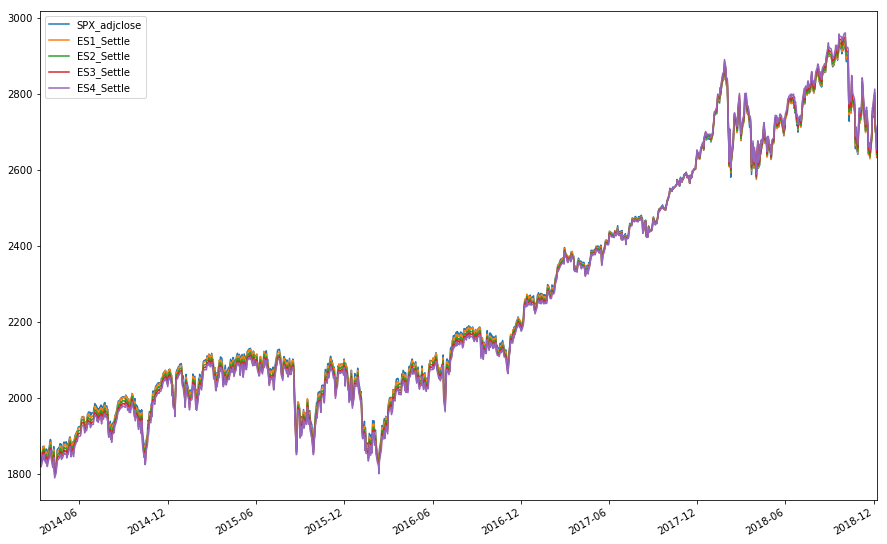

In [96]:
df = pd.concat([spx, es1, es2, es3, es4],axis = 1).dropna()
df[['SPX_adjclose', 'ES1_Settle', 'ES2_Settle', 'ES3_Settle', 'ES4_Settle']].plot(figsize = (15,10))